## Mini-Lab Logistic Regression & SVMs
##### Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

### Project Overview

The purpose of this data set is to predict whether or not individual credit card clients (in Taiwan) will default.

The primary explanatory variables include:
- Six months of Payment Amounts, Billed Amounts and the Timeliness of each Payment.
- Demographic information: Marital Status, Sex, Age and Level of Education.
    
A description of all variables in the data set is provided in the last cell of this notebook for reference.


### Data Preparation
In order to assess our model we will begin by reading in the data and performing some of the data transformations that we documented in Lab 1.

##### Feature Transformation/Encoding/Engineering
Below we go through the processes of preparing our data for the model based on the data preparation that we discussed in detail as part of Lab 1.


In [1]:
#import all packages for this notebook
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('data/DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)


# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
df = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#Create a separate dataset in case we need to come back to original
dfsub = df.copy()
#dfsub = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#We will not need these attributes. We are using log of them instead.
del dfsub['LIMIT_BAL']
del dfsub['PAY_AMT1']
del dfsub['PAY_AMT2']
del dfsub['PAY_AMT3']
del dfsub['PAY_AMT4']
del dfsub['PAY_AMT5']
del dfsub['PAY_AMT6']

#We found in Lab1 that there is high correlation between BILL Amount and Pay 
##Amounts so ignore bill amount for now
del dfsub['BILL_AMT1']
del dfsub['BILL_AMT2']
del dfsub['BILL_AMT3']
del dfsub['BILL_AMT4']
del dfsub['BILL_AMT5']
del dfsub['BILL_AMT6']

#Drop variables for which we used one-hot encoding
del dfsub['EDUCATION']
del dfsub['MARRIAGE']

In [2]:
dfsub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
SEX              30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
default          30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
EDUCATION_1      30000 non-null uint8
EDUCATION_2      30000 non-null uint8
EDUCATION_3      30000 non-null uint8
EDUCATION_4      30000 non-null uint8
MARRIAGE_1       30000 non-null uint8
MARRIAGE_2       30000 non-null uint8
MARRIAGE_3       30000 non-null uint8
dty

From above we are able to see that we have 22 total features that are now all of a numerical type that we will be using to predict our the class of our target, "default".

##### Splitting the training/test data set

There are 30,000 observations in this dataset that we now split into training/test sets (80/20 split) that we can use to assess the performance of our two models.

In [3]:
#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in dfsub:
    y = dfsub['default'].values
    del dfsub['default'] 
    X = dfsub.values

#Create a reuseable cv_object:  Random State keeps the seed.
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2,random_state=0)

#train_indices
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Dimensions of training features are  (24000, 22)
Dimensions of training target are  (24000,)
Dimensions of testing features are  (6000, 22)
Dimensions of testing target are  (6000,)


##### Scale the data
From above we see that we succesfully split our training/test sets split up 80/20 with 24000 obs in the training data and 6000 in our test set.

Once we have our datasets split up we can now use our training data to calculate the mean & standard deviation to scale our continuous variables. It is important to not let the values from the test data be used in the calculation of the mean & standard deviation as this may accidently provide you insights into the test data that you should not have in your model training.

In [4]:
from sklearn.preprocessing import StandardScaler
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


### Logistic Regression Model
After we scale our train & test sets we can start training our models. We will begin by training the Logisitc Regression model and explore the various options to assess the models performance. In order to compare these models we will compare them to a simple baseline model. For this our baseline is just assuming no customers will default. This is not an ideal solution, however it will give us a basic understanding of how much improvement we gain from the models we are comparing.

In [5]:
unique, counts = np.unique(y_test, return_counts=True)
freq = np.asarray((unique, counts)).T
nodefault = freq[0,1]
default = freq[1,1]
total = default+nodefault


print('Frequency of Non-Default vs Defualt')
print(freq)
print('Baseline Accuracy: ' , (nodefault/total))


Frequency of Non-Default vs Defualt
[[   0 4713]
 [   1 1287]]
Baseline Accuracy:  0.7855


Provided the baseline accuracy of 78.55% all models that we consider should be able to perform as well or better than this initial baseline. 

*For future work we will more closely consider other metrics such as precision, recall, & specificity in our baseline, but the purposes of this assignment accuracy is the key metric from which we will compare to.*


In [6]:

# train the model
lr_clf = LogisticRegression(penalty='l2', C=.05) 
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('accuracy:', acc )
print(conf )

# weights = pd.Series(lr_clf.coef_[0],index=dfsub.columns).sort_values(ascending = False)
# weights.plot(kind='bar')
# plt.show()

accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]


##### Initial Assessment: 

With the sklearn default parameters, the accuracy of this model is more than 81%, however a closer inspection of the confusions matrix provides us some key insights into the model's performance.

- Accuracy is similar to the overall share of Negative cases in the set.
- Specificity (True Negatives/Total Actual Negatives) is 96%, but
- Sensitivity/Recall (True Positives/Total Actual Positives) is only 27%.
- Precision:  Only 66% of the predicted positives were correct.

The overall accuracy is a modest improvement over our baseline model, and the we are able to succesfully identify over half of the default payments. However, we would ideally like to improve this number. So lets play with some of the model parameters to see if we can lift our overall accuracy any further.

### Tuning

In [7]:
# Setting three alternatives for C
Param = [.05,1.0,20.0]

for z in Param:
    lr_clf = LogisticRegression(penalty='l2', C=z, class_weight=None) 
    lr_clf.fit(X_train_scaled,y_train)  # train object

    y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print('C=', z, 'Class_Weight=None')
    print('accuracy:', acc )
    print(conf )
    
print('________________________________________')
print('Using Balance Class Weight')
print('________________________________________')
for z in Param:
    lr_clf = LogisticRegression(penalty='l2', C=z, class_weight='balanced') 
    lr_clf.fit(X_train_scaled,y_train)  # train object

    y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print('C=', z, 'Class_Weight=balanced')
    print('accuracy:', acc )
    print(conf )

C= 0.05 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
C= 1.0 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
C= 20.0 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
________________________________________
Using Balance Class Weight
________________________________________
C= 0.05 Class_Weight=balanced
accuracy: 0.7281666666666666
[[3560 1153]
 [ 478  809]]
C= 1.0 Class_Weight=balanced
accuracy: 0.7285
[[3563 1150]
 [ 479  808]]
C= 20.0 Class_Weight=balanced
accuracy: 0.7285
[[3563 1150]
 [ 479  808]]


##### Adjusting Model Parameters

Impact of tuning C is negligible.  The number of True and False Negatives is unchanged, and the number of True and False positives only changed by one.
Impact on overall accuracy was negligible as well.

Impact of using standard scaler vs not using it (not shown) was also very small.

Using balanced Class_Weight does change performance.
- Accuracy drops to just under 73%.
- Precision drops to 41% from 66%.
- Specificity drops to 76% from 96%, but
- Recall increases to 63% from 27%.

Based on what we were able to determine our initial model, using the scaled features and the default logistic regresssion parameters from sklearn provided the best fit of our data.

#### Feature Importance of the Logistic Model

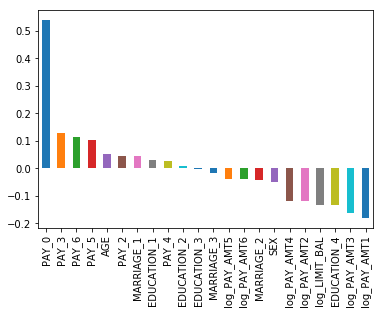

In [8]:
# train the model
lr_clf = LogisticRegression(penalty='l2', C=.05) 
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

weights = pd.Series(lr_clf.coef_[0],index=dfsub.columns)
weights2 = weights.sort_values(ascending = False)
weights2.plot(kind='bar')
plt.show()

#df_c = df_c.sort_values('Count')

##### Interpretation of Weights from Logistic Model

- The most important feature in predicting delinquency is how delinquent the most recent payment was.  The more delinquent the payment, the more likely the account is to default.  The second most important feature is the log of the most recent payment amount.  The higher the payment, the less likely the account is to default.  All of this is consistent with intuitive expectations.

- In general, the most important features are the delinquency status of some payments made, the amounts paid and the credit limit.  We are ignoring the Education Level 4, because that is a catch-all category with few values.

We are struck by the preponderance of low weights in this data set.  This could be due to:
- The existence of serial correlation among variables, which include sequential payments and the tendency of customers to be consistent in terms of the delinquency of the payments they make from month to month.  

- We may need to include additional (calculated) variables, such as the number of times delinquent.
- We may need to segment customers into groups, for example light and heavy users of their cards.
- The relationship between certain explanatory variables and the response may not be modeled correctly.  For example, the "Pay" (Delinquency) variables are ordinal, and we are treating them as continuous.  We may need to treat them as categorical.



### Support Vector Machines
From the logistic regression model we were able to improve our overall accuracy over baseline from ~79% to ~81%. We will next explore how a support vector machine model can help us improve our model performance even further and evalauate the feature importance of the best performing SVM model.

Same as before we will begin with the default model and then explore tuning various parameters from there.

In [9]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC() # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8258333333333333
[[4508  205]
 [ 840  447]]


##### Initial Assessment: 

With the sklearn default parameters, we see the overall accuracy of this model improve to ~83%. Similarly we also see some changes in our other key metrics as well.

- Accuracy is similar to the overall share of Negative cases in the set.
- Specificity (True Negatives/Total Actual Negatives) is 96%, but
- Sensitivity/Recall (True Positives/Total Actual Positives) is only 35%.
- Precision: 69% of the predicted positives were correct.

Based on this we do see that the SVM model was able to improve all of our metrics above what we were able to acheive using the Logistic regression model. However, lets see if we can improve the model further by exploring different model parameters. Below we will explore the use of the grid search to help us identify what parameters provide us the best overall accuracy for our data.

In [10]:
#Logisitic regression 10-fold cross-validation 

svcEstimator = SVC()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = { 'C': [0.01, 0.1, 1]
              ,'kernel': ['rbf','linear']
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 5
                    , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
svcGridSearch.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.01, 0.1, 1], 'kernel': ['rbf', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [11]:
#Display the best estimator parameters
svcGridSearch.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

##### Adjusting Model Parameters

Usinger the grid search algorithm the best estimator based on 3-fold cross validation is the same estimator that was trained using the sklearn default parameters.

Below outlines the parameter options that were included in the grid search:
 1)A Penalty Parameter of C = (0.01, 0.1, 1) 
 2) Also compared the fits using the radial basis function kernel vs a linear kernel.

As part of this grid search we compared 18 possible model fits the best fit was the model with a penalty parameter = 1 & used the rbf kernel. 

Based on the results of the grid search our initial model, using the scaled features and the default support vector machiner parameters from sklearn provided the best fit of our data.

*Additional model parameters were included in a grid search testing > 90 different fites and still the default model appeared to have the best fit for our data*

#### Reviewing the Chosen Support Vectors 
Since we do not use a linear kernel our final model determining our relative feature importance is more difficult than looking into the weights from the logistic regression model. However, while we are unable directly determine the relative feature importance we can look at the chosen support vectors and see if they offer any insights into our model.

For this we will focus on the top three most important variables as determined by the logistic model to determine how the original data statistics compare to the chosen support vectors from the model. Those three variables are: PAY_0, log_PAY_AMT1, & log_LIMIT_BAL.


(10393, 22)
(10393,)
[5688 4705]


C:\Users\bsnxw01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


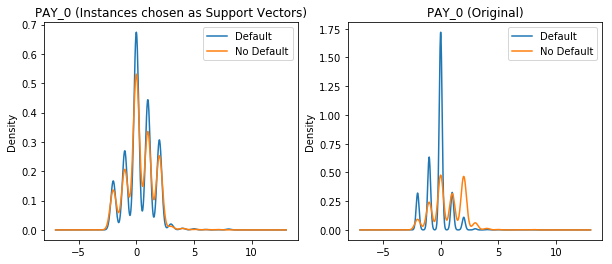

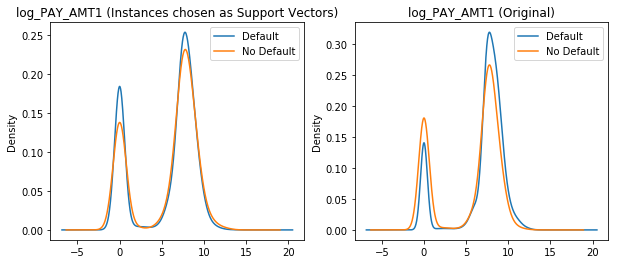

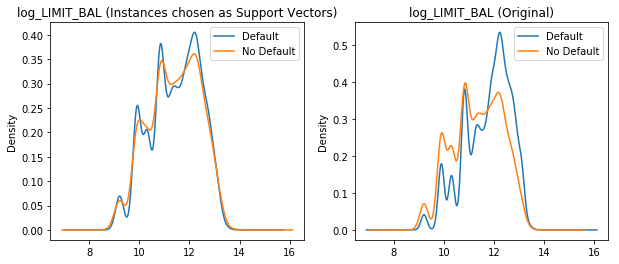

In [19]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

# make a dataframe of the training data
df_tested_on = dfsub.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['default'] = y[svm_clf.support_] 
dfsub['default'] = y # also add it back in for the original data

# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['default'])
df_grouped = dfsub.groupby(['default'])

# plot KDE of Different variables
vars_to_plot = ['PAY_0','log_PAY_AMT1','log_LIMIT_BAL']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Original)')


Based on the charts from above, we can see that the separation in three distributions is not as great as the separation for the original data. 

Given, that the chosen support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data. 

Once way to interpret this is that as we move closer towards the class boundaries the values of the three features share begin to share a more similar statistical profile between the two classes. Meaning the seperation of the two classes may be largely dependent on the values in these three features. 


### Comparing the Logistic Model to the Support Vector Machine

In conclusion were able to see several differences between our two models, in both performance and training times.

#### Peformance

*Logistic Regression*
Accuracy: 81%
Specificity: 96%
Sensitivity/Recall: 27%.
Precision: 66%

*SVM*
Accuracy:83%
Specificity: 96%, 
Sensitivity/Recall: 35%.
Precision: 69%


While neither model performed as well as desired for our project we did see a modest improvement in the SVM model. A lot of the differences in performance can be attributed to the regression model relied on a linear decision boundary. However, our final SVM model did not uses a linear decision boundary. 


#### Training Time
While we are able to see a modest performance improvement from the support vector machine lets compare the training time associated with these two models:

In [21]:
%%time

lr_clf = LogisticRegression(penalty='l2', C=.05) 
lr_clf.fit(X_train_scaled,y_train)  # train object


Wall time: 250 ms


In [23]:
%%time

# train the model just as before
svm_clf = SVC() # get object
svm_clf.fit(X_train_scaled, y_train)  # train object


Wall time: 49.7 s


Based on the results above we can see that the logistic regression model is able to train on 24,000 observation in 250 ms. Meanwhile the SVC model takes almost a minute to train. 

This quite a drastic difference in the training time. The training time of the support vector machine impacted more directly by the number of observations in the data because how the decision boundary is calculater. However, in the case of logistic regression the time it takes for the model to converge on minimum cost function is not related to the the number of observations but rather then number of features.

## APPENDIX:  Description of the Data Set

#### Attribute Information
The data used is "Default of Credit Card Clients" from UCI. It was attained by I-Cheng Yeh with Chung Hua University and Tamkang University in Taiwan. The original goal was to predict default rates.

The data has a 6 month history of 30,000 Taiwanese credit account balances and transactions. Each observation contains a binary reponse variable "default" with values 1 indicating a default occured and 0 indicating no default occured.

The following explanatory variables are included:

 - LIMIT_BAL = Total credit amount allowed
 
 - SEX
     -  1 = Male
     -  2 = Female
 
 - EDUCATION
     - 1 = Graduate School
     - 2 = University
     - 3 = High School
     - 4 = Other
   
 - MARRIAGE
     - 1 = Married
     - 2 = Single
     - 3 = Other
       
 - AGE = Credit holder age in years
 
Payment history (2005)
 - PAY_0 = September
 - PAY_2 = August
 - PAY_3 = July
 - PAY_4 = June
 - PAY_5 = May
 - PAY_6 = April
      -  -1 = payment received on time
      -   1 = payment received one month late
      -   2 = payment received two months late
      -   "......"
      -   9 = payment received nine months late or more
         
Statement amount (NT dollars, 2005)
 - BILL_AMT1 = September
 - BILL_AMT2 = August
 - BILL_AMT3 = July
 - BILL_AMT4 = June
 - BILL_AMT5 = May
 - BILL_AMT6 = April
 
Payment amount (NT dollars, 2005).
 - PAY_AMT1 = September
 - PAY_AMT2 = August
 - PAY_AMT3 = July
 - PAY_AMT4 = June
 - PAY_AMT5 = May
 - PAY_AMT6 = April

Original Source Data Set Information  
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#